- http://keunwoochoi.blogspot.com/2016/03/2.html
- http://www.rex-ai.info/docs/AI_Example_CNN_speech_recognize
- https://www.youtube.com/watch?v=oltGIc4uo5c
- https://youdaeng-com.tistory.com/5

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import cv2
from torchvision import transforms, datasets
import pandas as pd
import os
from glob import glob

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.10.0  Device :  cuda


# SVD 문장 데이터에서 Feature 추출
- mfcc

In [2]:
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt
#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.
sr=50000
win_length =  np.int64(50000/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.

In [3]:
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt
#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.
sr=50000
win_length =  np.int64(50000/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.

pathology_sig=[]
healthy_sig=[]

pathology=[]
healthy=[]


#PATHOLOGY DATA
for audio_path in os.listdir('../voice_data/disorder/export/'):
    sig, sr = librosa.load('../voice_data/disorder/export/'+audio_path, sr=50000)# 논문에서 f_s = 50 000HZ
    pathology_sig.append(sig)
    MFCCs = librosa.feature.mfcc(sig, sr, win_length=win_length ,n_fft=n_fft, hop_length=hop_length, n_mfcc=13)
    pathology.append(MFCCs)
    

#Healthy data
for audio_path in os.listdir('../voice_data/healthy/export/'):
    sig, sr = librosa.load('../voice_data/healthy/export/'+audio_path, sr=50000)# 논문에서 f_s = 50 000HZ
    healthy_sig.append(sig)
    MFCCs = librosa.feature.mfcc(sig, sr, win_length=win_length ,n_fft=n_fft, hop_length=hop_length, n_mfcc=13)
    healthy.append(MFCCs)
    
print("pathology data 수 : ",len(pathology))
print("healthy data 수 : ",len(healthy))


path_max=max([ len(samples) for samples in pathology_sig])
healthy_max=max([ len(samples) for samples in healthy_sig])
print("가장 긴 path sample :" ,path_max)
print("가장 긴 healthy sample :" ,healthy_max)

pathology data 수 :  852
healthy data 수 :  632
가장 긴 path sample : 317967
가장 긴 healthy sample : 207017


In [4]:
print(path_max/sr,"초")
print(healthy_max/sr,"초")

6.35934 초
4.14034 초


# 결과 확인
- 1 row당 1 frame으로

In [30]:
len(healthy[0][2]) #1번 : 파일. 2번:mfcc
headers = "mfcc1 mfcc2 mfcc3 mfcc4 mfcc5 mfcc6 mfcc7 mfcc8 mfcc9 mfcc10 mfcc11 mfcc12 mfcc13".split()
pd.DataFrame(healthy[0].T,columns=headers)



,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13
0,-277.435181,217.131302,-13.972048,2.421658,-46.796097,-4.302108,-28.972664,13.408556,28.633501,-23.682468,-10.976597,5.232002,-27.321705
1,-281.919495,210.899353,-14.512285,-0.058138,-50.630947,-8.609697,-39.469994,9.049422,23.882133,-24.983570,-13.507469,8.224895,-22.392838
2,-307.412170,182.036957,-23.609758,-1.286402,-46.687546,-8.553607,-44.500671,9.419307,23.425653,-21.788742,-17.821304,14.514274,-17.257675
3,-308.061707,185.260468,-20.746826,-2.282940,-47.517494,-8.603182,-44.703972,8.796711,28.302505,-13.937325,-18.596596,12.981836,-14.991493
4,-312.488892,183.100967,-23.440123,-1.653871,-47.008690,-9.748432,-45.852364,5.705857,24.955027,-18.747026,-19.271517,9.628666,-14.358886
...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,-312.916199,158.961182,-26.786573,13.924356,-51.417900,-6.173113,-41.896027,7.595150,21.323551,-27.307755,-14.366621,14.418139,-21.696594
308,-311.370911,161.326279,-22.441750,14.180597,-55.980904,-7.803135,-41.668770,11.216280,24.795391,-24.515268,-12.940067,13.673044,-19.685993
309,-316.772736,164.728607,-26.624262,11.242275,-57.082973,-11.883168,-40.423569,10.203865,23.440647,-26.331760,-14.870211,11.893984,-15.572662
310,-300.903534,186.152023,-21.547771,9.273628,-56.856239,-14.139202,-39.882935,4.801795,20.053015,-23.554581,-13.533127,12.452017,-12.816125


In [17]:
healthy[0].shape[1]

326

In [5]:
del pathology
del healthy
del pathology_sig
del healthy_sig

# 데이터 나누기
- pathology : 852 ,  healthy 수 :  632  총 1484
- train :  1187 , test : 297

In [6]:
#1. train, test 나누기
import os
import random #데이터 shuffle 사용
from glob import glob


pathology = glob('../voice_data/disorder/export/*.wav')
healthy = glob('../voice_data/healthy/export/*.wav')
print("Pathology : ",len(pathology))
print("Healthy: ",len(healthy))


X = pathology+healthy # mfcc 데이터 합
print("총 데이터수 : ",len(X))
Y = {} # 라벨
for idx,x in enumerate(X):
    if idx<852:
        Y[x]="pathology"
    else:
        Y[x]="healthy"

#train 1187   test: 297
random.shuffle(X)
DATA_TRAINING_PATH = X[:1186]
DATA_TEST_PATH = X[1187:]

print("훈련 셋 : ",len(DATA_TRAINING_PATH))
print("테스트 셋 : ",len(DATA_TEST_PATH))

Pathology :  852
Healthy:  632
총 데이터수 :  1484
훈련 셋 :  1186
테스트 셋 :  297


In [35]:
Y

{'../voice_data/pathology_a/export\\101-a_n.wav': 'pathology',
 '../voice_data/pathology_a/export\\1037-a_n.wav': 'pathology',
 '../voice_data/pathology_a/export\\1038-a_n.wav': 'pathology',
 '../voice_data/pathology_a/export\\1039-a_n.wav': 'pathology',
 '../voice_data/pathology_a/export\\1040-a_n.wav': 'pathology',
 '../voice_data/pathology_a/export\\1041-a_n.wav': 'pathology',
 '../voice_data/pathology_a/export\\1042-a_n.wav': 'pathology',
 '../voice_data/pathology_a/export\\1043-a_n.wav': 'pathology',
 '../voice_data/pathology_a/export\\1044-a_n.wav': 'pathology',
 '../voice_data/pathology_a/export\\1045-a_n.wav': 'pathology',
 '../voice_data/pathology_a/export\\1046-a_n.wav': 'pathology',
 '../voice_data/pathology_a/export\\1047-a_n.wav': 'pathology',
 '../voice_data/pathology_a/export\\1048-a_n.wav': 'pathology',
 '../voice_data/pathology_a/export\\1049-a_n.wav': 'pathology',
 '../voice_data/pathology_a/export\\105-a_n.wav': 'pathology',
 '../voice_data/pathology_a/export\\1050-a

# 데이터 정의
- 추가적으로 데이터의 크기를 맞춰주기 위해 3초로 padding 및 truncate 실시 https://sequencedata.tistory.com/25 FixAudioLength
- 논문에서는 400frame으로 설정.(여기서는 500frame)
- 전처리 방법 결정.


In [248]:
from torch.utils.data import Dataset, DataLoader

classes = ["pathology","healthy"]
sr=50000
win_length =  np.int64(50000/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.



class svd_dataset(Dataset):
    def __init__(self,data_path_list,classes,transform=None):
        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        self.path_list = data_path_list
        self.label = svd_dataset.get_label(data_path_list)
        self.classes=classes
        self.transform=transform
    
    @classmethod
    def get_label(cls,data_path_list):
        label_list=[]
        for idx in data_path_list:
            label_list.append(Y[idx])
        #print(label_list)
        return label_list
    
    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다. 
        
    def __getitem__(self, idx):
        """
        학습에 사용할 이미지를 반환하면 된다. 이 함수는 인풋으로 index를 받는다. 
        path_list에서 index에 해당하는 이미지를 읽으면 된다. 
        이때 텐서형태의 인풋이 들어오기때문에 리스트로 변환하여준다.(굳이 안해도됨)
        반환값으로는 경로로부터 읽어들여 transform을 적용한 이미지 파일과 정답에 해당하는 클래스를 반환하면 된다.
        이때, 클래스를 숫자로 반환하여야 한다. 
        예를들면 Good: 0 Bad:1. 클래스 리스트의 index로 반환하게 구현하였다.
        """
        #mfcc = X[self.path_list[idx]].T
        #print(self.path_list[idx])
        sig, sr = librosa.load(self.path_list[idx], sr=50000)# 논문에서 f_s = 50 000HZ
        

        
        MFCCs = librosa.feature.mfcc(sig, sr, win_length=win_length ,n_fft=n_fft, hop_length=hop_length, n_mfcc=13)
        #mfcc 400 FRAME이 되도록 패딩.
        length = 500
        pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
        MFCCs = pad2d(MFCCs, length)
        MFCCs=MFCCs.T
        
        
        
        if self.transform:
            #print('transform')
            MFCCs=self.transform(MFCCs).type(torch.float32)# 데이터 0~1 정규화
        else:
            #print("else")
            MFCCs = torch.from_numpy(MFCCs).type(torch.float32)# 이미지 0~1 정규화
            MFCCs=MFCCs.unsqueeze(0)#cnn 사용위해서 추가
            #MFCCs = MFCCs.permute(2, 0, 1)
        return MFCCs, self.classes.index(self.label[idx])
    

# 데이터 로더

In [249]:
#3. 하이퍼 파라미터
BATCH_SIZE =  32 #한 배치당 32개 음성데이터
EPOCHS = 50 # 전체 데이터 셋을 50번 반복

In [250]:
#DATA LOADER 함수가 BATCH_size 단위로 분리해 지정.
train_loader = torch.utils.data.DataLoader(dataset = 
                                           svd_dataset(
                                               DATA_TRAINING_PATH,
                                               classes,
                                               transform = transforms.ToTensor()#이걸 composed로 고쳐서 전처리 하도록 수정.
                                           ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = True,
                                           ) # 순서가 암기되는것을 막기위해.


test_loader = torch.utils.data.DataLoader(dataset = 
                                           svd_dataset(
                                               DATA_TEST_PATH,
                                               classes,
                                               transform = transforms.ToTensor()
                                           ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = False,) # 순서가 암기되는것을 막기위해.



# 데이터 확인

X_train :  torch.Size([32, 1, 500, 13]) type: torch.FloatTensor
Y_train :  torch.Size([32]) type: torch.LongTensor
tensor(1)


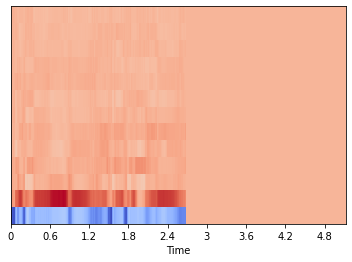

In [251]:
# 4. 데이터 확인하기
for (X_train,Y_train) in train_loader:
    print("X_train : ",X_train.size(),'type:',X_train.type())
    print("Y_train : ",Y_train.size(),'type:',Y_train.type())
    break
    
X_train[0]
print(Y_train[0])
librosa.display.specshow(X_train[0].numpy().squeeze(0).T, sr=50000, x_axis='time')
#batch: 32 / frame수: 500  /  feature수: 13

tensor(1)


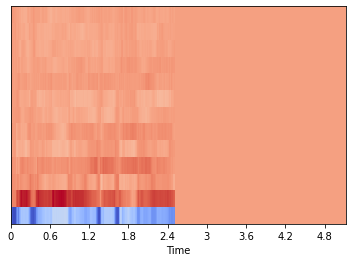

In [253]:
print(Y_train[1])
librosa.display.specshow(X_train[1].numpy().squeeze(0).T, sr=50000, x_axis='time')

tensor(0)


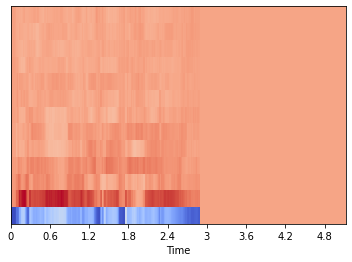

In [137]:
print(Y_train[2])
librosa.display.specshow(X_train[2].numpy().squeeze(0).T, sr=50000, x_axis='time')

tensor(1)


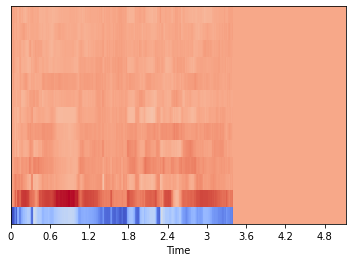

In [254]:
print(Y_train[3])
librosa.display.specshow(X_train[3].numpy().squeeze(0).T, sr=50000, x_axis='time')

tensor(1)


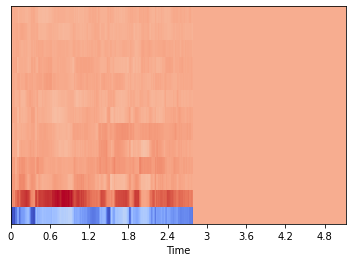

In [255]:
print(Y_train[5])
librosa.display.specshow(X_train[5].numpy().squeeze(0).T, sr=50000, x_axis='time')

# CNN

In [256]:
#6 -3. CNN 모델
# 6-2. 모델. drop out 추가.
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__() # 상속받기
        #컨볼루션 커널 정의 및 컨볼루션 레이어
        self.conv1 = nn.Conv2d(
            in_channels = 1,# 채널이 1개
            out_channels = 4,# FeatureMap 수,커널 수
            kernel_size = 3,#3x3
            padding=1,#제로패딩.크기 유지
        )
        self.batch_cnn1 = nn.BatchNorm2d(4)
        
        #결과로 1개의 평면이 -> 8개의 피처맵으로.
        self.conv2 = nn.Conv2d(
            in_channels = 4,# featureMap 8개
            out_channels = 8,# FeatureMap 수,커널 수
            kernel_size = 3,#3x3
            padding=1,#제로패딩.크기 유지
        )
        self.batch_cnn2 = nn.BatchNorm2d(8)
        
        self.pool = nn.MaxPool2d(
            kernel_size = 2,
            stride = 2
        )
        #이미지의 크기가 4분의 1줄어든다.
        
        #Fully-connected layer
        self.fc1 = nn.Linear(125*3*8,500)# pooling두번해서 125*3
        self.batch_norm1 = nn.BatchNorm1d(500)
        self.fc2 = nn.Linear(500,250)
        self.batch_norm2 = nn.BatchNorm1d(250)
        #self.fc3 = nn.Linear(250,100)
        #self.batch_norm3 = nn.BatchNorm1d(100)
        self.fc4 = nn.Linear(250,2)#2개 클래스
    
    def forward(self,x):
        x = self.conv1(x)#flatten 없어도 된다.
        #x = self.batch_cnn1(x)
        x = F.relu(x)
        #x = F.dropout2d(x,training=self.training,p=0.5)
        x = self.pool(x)
        
        x = self.conv2(x)
        #x = self.batch_cnn2(x)
        x = F.relu(x)
        #x = F.dropout2d(x,training=self.training,p=0.5)
        x = self.pool(x)
        
        x = x.view(-1,125*3*8)#피처맵을 flatten
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        # = F.dropout(x,training=self.training,p=0.5)

        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = F.dropout(x,training=self.training,p=0.5)
        
        #x = self.fc3(x)
        #x = self.batch_norm3(x)
        #x = F.relu(x)
        ##x = F.dropout(x,training=self.training,p=0.5)
        
        x = self.fc4(x)
        x = F.log_softmax(x,dim=1)#2개 클래스
        #print(x)
        return x

In [308]:
#6 -3. CNN 모델
# 6-2. 모델. drop out 추가.
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__() # 상속받기
        #컨볼루션 커널 정의 및 컨볼루션 레이어
        self.conv1 = nn.Conv2d(
            in_channels = 1,# 채널이 1개
            out_channels = 32,# FeatureMap 수,커널 수
            kernel_size = (1,13),#1x13  no padding
        )
        self.batch_cnn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(
            in_channels = 32,# 채널이 32개
            out_channels = 64,# FeatureMap 수,커널 수
            kernel_size = (27,1),#27 x 1 no padding
        )
        self.batch_cnn2 = nn.BatchNorm2d(64)
        #결과 : torch.Size([32, 64, 474, 1])
        
        #이미지의 크기가 4분의 1줄어든다.
        
        #Fully-connected layer
        self.fc1 = nn.Linear(64*474*1,2)# pooling두번해서 125*3
        #self.batch_norm1 = nn.BatchNorm1d(500)
        #self.fc2 = nn.Linear(500,250)
        #self.batch_norm2 = nn.BatchNorm1d(250)
        #self.fc3 = nn.Linear(250,100)
        #self.batch_norm3 = nn.BatchNorm1d(100)
        #self.fc4 = nn.Linear(500,2)#2개 클래스
    
    def forward(self,x):
        x = self.conv1(x)#flatten 없어도 된다.
        x = self.batch_cnn1(x)
        x = F.relu(x)
        x = F.dropout2d(x,training=self.training,p=0.5)
        #x = self.pool(x)
        
        x = self.conv2(x)
        x = self.batch_cnn2(x)
        x = F.relu(x)
        x = F.dropout2d(x,training=self.training,p=0.5)
        
        x = x.view(-1,64*474*1)#피처맵을 flatten
        x = self.fc1(x)
        x = F.log_softmax(x,dim=1)#2개 클래스
        #print(x)
        return x

In [309]:
#7. Optimizer, Objective Function
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()
#원핫 인코딩값의 loss는 crossEntropyLoss로 비교
print(model)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(1, 13), stride=(1, 1))
  (batch_cnn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(27, 1), stride=(1, 1))
  (batch_cnn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=30336, out_features=2, bias=True)
)


In [310]:
#8. 학습
def train(model,train_loader,optimizer, log_interval):
    model.train()
    correct = 0
    for batch_idx,(image,label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        #데이터들 장비에 할당
        optimizer.zero_grad() # device 에 저장된 gradient 제거
        output = model(image) # model로 output을 계산
        loss = criterion(output, label) #loss 계산
        loss.backward() # loss 값을 이용해 gradient를 계산
        optimizer.step() # Gradient 값을 이용해 파라미터 업데이트.
        
        if batch_idx % log_interval == 0 and batch_idx!=0:
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
            train_accuracy = 100. * correct / len(label)
            print("Train, Epoch: {} \tTrain Loss: {:.6f}\t Train Accuracy: {:.2f} %\n".format(
            Epoch,loss.item(),train_accuracy) )
        

In [311]:
#9. 학습 진행하며, test 데이터로 모델 성능확인
def evaluate(model,test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            #print(output)
            #label.type(torch.FloatTensor).to(DEVICE)
            test_loss += criterion(output, label).item()
            #prediction = output >= threshold
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
            #true.false값을 sum해줌. item
        test_loss /= len(test_loader.dataset)
        test_accuracy = 100. * correct / len(test_loader.dataset)
        return test_loss,test_accuracy
            

In [312]:
#10. 학습 및 평가.
for Epoch in range(1,EPOCHS+1):
    train(model,train_loader,optimizer,log_interval=32)
    test_loss,test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH:{}], \tTest Loss:{:.4f} \tTest Accuracy: {:.2f} %\n".
          format(Epoch,test_loss,test_accuracy))

Train, Epoch: 1 	Train Loss: 3.401358	 Train Accuracy: 53.12 %


[EPOCH:1], 	Test Loss:0.1028 	Test Accuracy: 51.85 %

Train, Epoch: 2 	Train Loss: 1.481851	 Train Accuracy: 56.25 %


[EPOCH:2], 	Test Loss:0.0238 	Test Accuracy: 77.44 %

Train, Epoch: 3 	Train Loss: 0.997860	 Train Accuracy: 68.75 %


[EPOCH:3], 	Test Loss:0.0441 	Test Accuracy: 67.68 %

Train, Epoch: 4 	Train Loss: 1.264887	 Train Accuracy: 59.38 %


[EPOCH:4], 	Test Loss:0.0785 	Test Accuracy: 51.18 %

Train, Epoch: 5 	Train Loss: 1.781829	 Train Accuracy: 65.62 %


[EPOCH:5], 	Test Loss:0.0192 	Test Accuracy: 77.10 %

Train, Epoch: 6 	Train Loss: 0.642234	 Train Accuracy: 75.00 %


[EPOCH:6], 	Test Loss:0.0185 	Test Accuracy: 78.45 %

Train, Epoch: 7 	Train Loss: 0.927928	 Train Accuracy: 65.62 %


[EPOCH:7], 	Test Loss:0.0198 	Test Accuracy: 73.06 %

Train, Epoch: 8 	Train Loss: 1.251517	 Train Accuracy: 62.50 %


[EPOCH:8], 	Test Loss:0.0215 	Test Accuracy: 79.46 %

Train, Epoch: 9 	Train Loss: 0.775011	 Train Acc

KeyboardInterrupt: 

In [17]:
#크기 알아보기
m = nn.MaxPool2d(2, stride=2)
#m = nn.MaxPool2d((3, 2), stride=(2, 1))
input = torch.randn(32, 1, 500, 13)
print(input.size())
output = m(input)
print(output.size())
output = m(output)
print(output.size())

torch.Size([32, 1, 500, 13])
torch.Size([32, 1, 250, 6])
torch.Size([32, 1, 125, 3])


In [302]:
input = torch.randn(32, 1, 500, 13)
m=nn.Conv2d(
            in_channels = 1,# 채널이 1개
            out_channels = 32,# FeatureMap 수,커널 수
            kernel_size = (1,13),#1x13  no padding
        )
output=m(input)
print(output.size())
m=nn.Conv2d(
            in_channels = 32,# 채널이 1개
            out_channels = 64,# FeatureMap 수,커널 수
            kernel_size = (27,1),#9 x 1 no padding
        )
output=m(output)
print(output.size())


torch.Size([32, 32, 500, 1])
torch.Size([32, 64, 474, 1])


In [295]:
input = torch.randn(32, 1, 64, 44)
m=nn.Conv2d(
            in_channels = 1,# 채널이 1개
            out_channels = 32,# FeatureMap 수,커널 수
            kernel_size = (64,1),#1x13  no padding
        )
output=m(input)
print(output.size())
m=nn.Conv2d(
            in_channels = 32,# 채널이 1개
            out_channels = 64,# FeatureMap 수,커널 수
            kernel_size = (1,9),#9 x 1 no padding
        )
output=m(output)
print(output.size())

torch.Size([32, 32, 1, 44])
torch.Size([32, 64, 1, 36])


In [180]:
input.size()

torch.Size([32, 1, 500, 13])

In [207]:
input = torch.randn(500, 13)

out=torch.stack([input,input,input])
out.size()

torch.Size([3, 500, 13])